# Tarea 4 - Data Cleaning

## Library

In [233]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures

get database and show first 5 rows

In [234]:
df = pd.read_csv('nyc_taxi_hw.csv')
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


## 1. Data Cleaning

In [235]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         100000 non-null  int64  
 1   key                100000 non-null  object 
 2   fare_amount        100000 non-null  float64
 3   pickup_datetime    100000 non-null  object 
 4   pickup_longitude   100000 non-null  float64
 5   pickup_latitude    100000 non-null  float64
 6   dropoff_longitude  100000 non-null  float64
 7   dropoff_latitude   100000 non-null  float64
 8   passenger_count    100000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 6.9+ MB


check for missing values

In [236]:
print(df.isnull().sum())

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


check for duplicate values

In [237]:
print(df.duplicated().sum())

0


There are no empty nor duplicated values

#### now well check for inconsistencies in the data

Graph the data for fare ammount

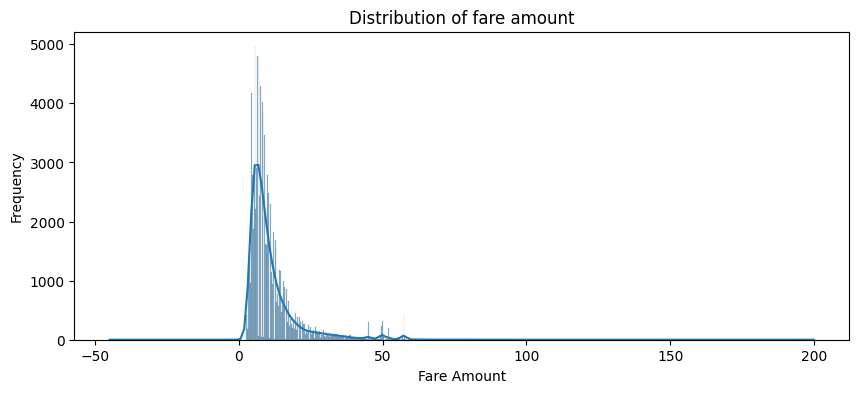

In [238]:
plt.figure(figsize=(10, 4))
sns.histplot(df['fare_amount'], kde=True)
plt.title('Distribution of fare amount')
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')
plt.show()

Check for negative or zero values in fare amount

In [239]:
belowzerocount = (df['fare_amount'] <= 0).sum()
print(f"Number of fare_amount lower than zero: {belowzerocount}")

Number of fare_amount lower than zero: 12


Now check for "unreasonably high values in fare_amount

In [240]:
upperboundcount = (df['fare_amount'] > 150).sum()
print(f"Number of fare_amount lower than zero: {upperboundcount}")

Number of fare_amount lower than zero: 7


From this information, we can see that there are 12 values that are equal to or below zero, which is not reasonable in this context. For the upper bound, if we assume it should not exceed 150, there are 7 rows with unreasonably high fares. Considering these inconsistencies, we will remove these values

In [241]:
df = df[(df['fare_amount'] >= 0) & (df['fare_amount'] <= 150)]

Now well graph fare_amount

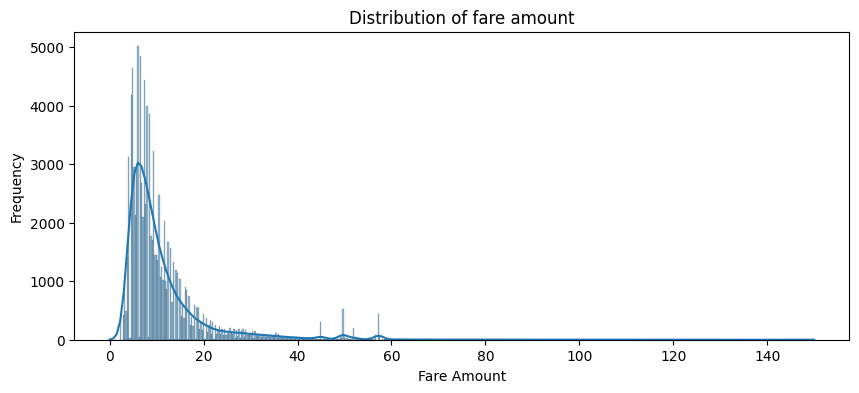

In [242]:
plt.figure(figsize=(10, 4))
sns.histplot(df['fare_amount'], kde=True)
plt.title('Distribution of fare amount')
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')
plt.show()

Afetr removing those extreme outliers, we can see the graph shows some very high ammounts. To better determine a good upper bound well find the 99th percentile and make it the upper bound, then remove values above it

In [243]:
# Calculate the 95th and 99th percentiles
upperBound = df['fare_amount'].quantile(0.99)
print("upperBound: ", upperBound)

df = df[df['fare_amount'] <= upperBound]

upperBound:  52.0


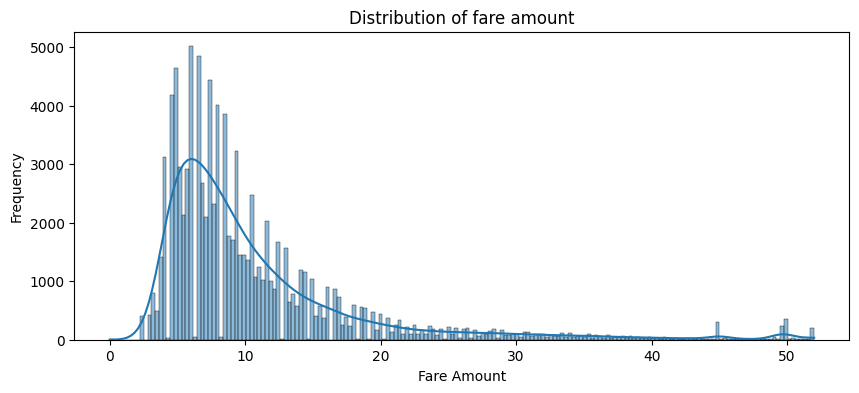

In [244]:
plt.figure(figsize=(10, 4))
sns.histplot(df['fare_amount'], kde=True)
plt.title('Distribution of fare amount')
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')
plt.show()

This graph looks better for the fare_amount distribution.   
The "unamed" column does nothing, and the "key" column can replace it, so well drop it.

In [245]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


Well now check key Column:

In [246]:
print(df['key'].head(10))

0      2009-06-15 17:26:21.0000001
1      2010-01-05 16:52:16.0000002
2     2011-08-18 00:35:00.00000049
3      2012-04-21 04:30:42.0000001
4    2010-03-09 07:51:00.000000135
5      2011-01-06 09:50:45.0000002
6      2012-11-20 20:35:00.0000001
7     2012-01-04 17:22:00.00000081
8    2012-12-03 13:10:00.000000125
9     2009-09-02 01:11:00.00000083
Name: key, dtype: object


We can see it has values for date and time, which we already have in the data set so well remove them and replace it with an autoincremented value

In [247]:
df['key'] = range(1, len(df) + 1)
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,1,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,3,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,4,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,5,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


We will now check the 'pickup_datetime'. First, we'll separate the date from the time, then we'll check if the values are reasonable.

In [248]:
print(df['pickup_datetime'].head(10))

0    2009-06-15 17:26:21 UTC
1    2010-01-05 16:52:16 UTC
2    2011-08-18 00:35:00 UTC
3    2012-04-21 04:30:42 UTC
4    2010-03-09 07:51:00 UTC
5    2011-01-06 09:50:45 UTC
6    2012-11-20 20:35:00 UTC
7    2012-01-04 17:22:00 UTC
8    2012-12-03 13:10:00 UTC
9    2009-09-02 01:11:00 UTC
Name: pickup_datetime, dtype: object


In [249]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['pickup_date'] = df['pickup_datetime'].dt.date
df['pickup_time'] = df['pickup_datetime'].dt.time
df.drop(["pickup_datetime"], axis=1, inplace=True)
df.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_time
0,1,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15,17:26:21
1,2,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05,16:52:16
2,3,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18,00:35:00
3,4,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21,04:30:42
4,5,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09,07:51:00


Now check if new values are valid

In [250]:
print("Date range:", df['pickup_date'].min(), "to", df['pickup_date'].max())
print("Time range:", df['pickup_time'].min(), "to", df['pickup_time'].max())

Date range: 2009-01-01 to 2015-06-30
Time range: 00:00:00 to 23:59:57


With this, we've also created  **better columns** (point 2 for evaluation)

After checking the values of date and time, well check values of longitude and latitude. From investigation we can say the coordinates (Latitude) 40.5 to 41.0 cover south of the city to slightly north and (Longitude) -74.2 to -73.7 (covers east to west of the city). Well now check both pickup and dropoff columns to check the travels are inside the city.

In [251]:
# Define the latitude and longitude ranges
lat_range = (40.5, 41.0)
lon_range = (-74.2, -73.7)

# Check if the values are outside the ranges
out_of_range = df[
    ~(
        (df['pickup_latitude'].between(*lat_range)) &
        (df['pickup_longitude'].between(*lon_range)) &
        (df['dropoff_latitude'].between(*lat_range)) &
        (df['dropoff_longitude'].between(*lon_range))
    )
]

# Print the number of rows that are outside the ranges
print(f"Number of rows outside range: {len(out_of_range)}")

Number of rows outside range: 2186


Well now remove this rows from the dataset

In [252]:
# Keep only the rows that are within the ranges
df = df[
    (df['pickup_latitude'].between(*lat_range)) &
    (df['pickup_longitude'].between(*lon_range)) &
    (df['dropoff_latitude'].between(*lat_range)) &
    (df['dropoff_longitude'].between(*lon_range))
]
df.head()

,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_time
0,1,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15,17:26:21
1,2,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05,16:52:16
2,3,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18,00:35:00
3,4,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21,04:30:42
4,5,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09,07:51:00


## 3. Graph the Data

First, well graph the distribution of pickups next to the distribution of dropoffs, then well analyze

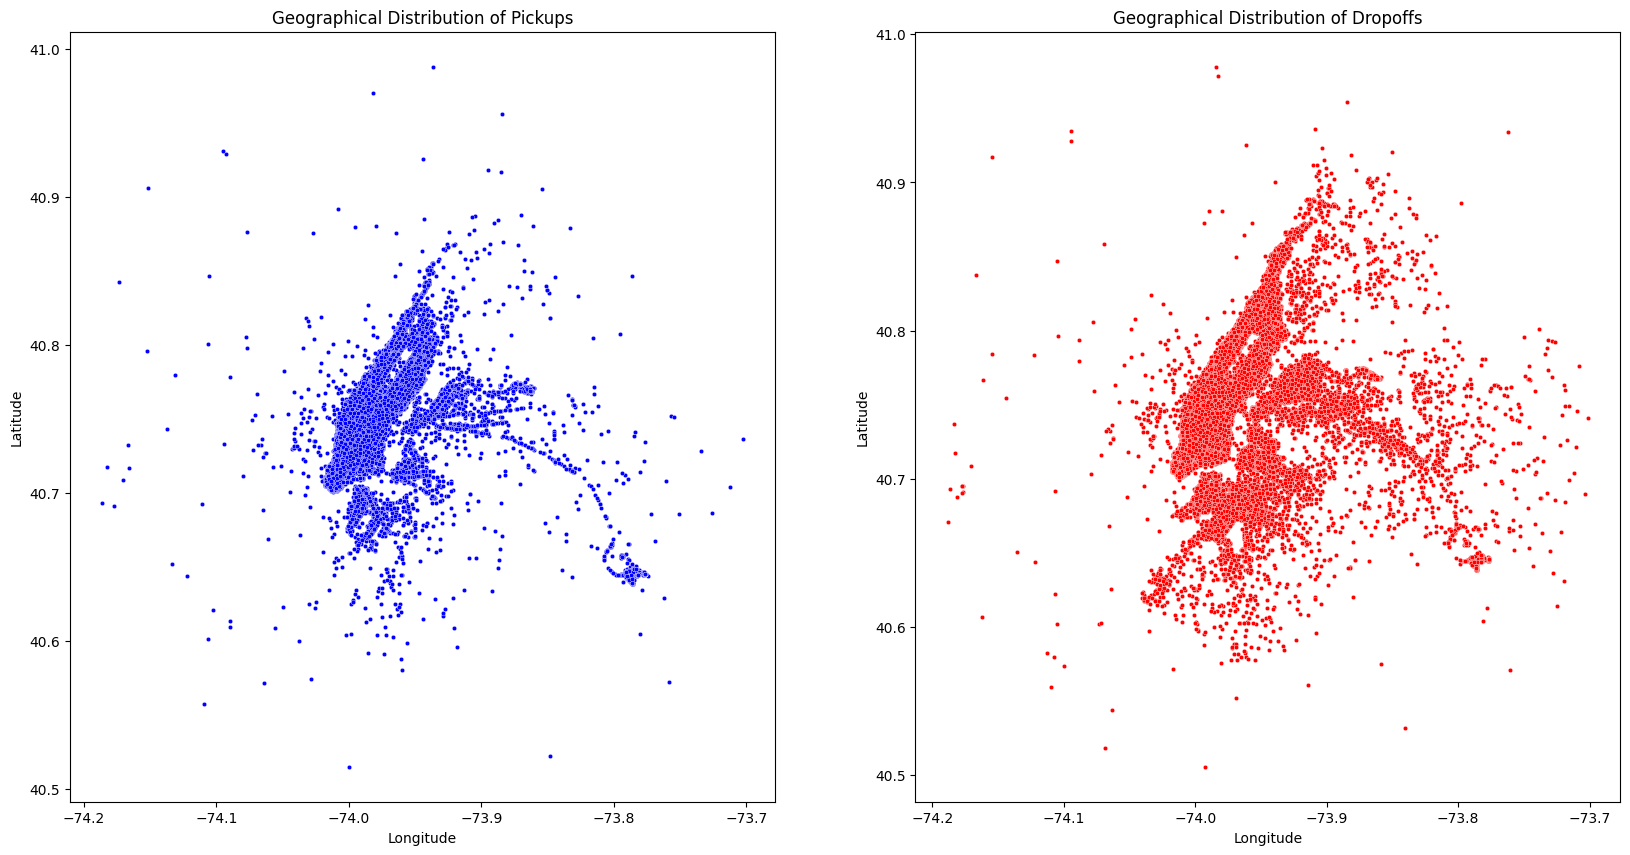

In [253]:
# Geographical Plot of Pickups and Dropoffs
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
sns.scatterplot(x='pickup_longitude', y='pickup_latitude', data=df, ax=ax[0], color='blue', s=10)
ax[0].set_title('Geographical Distribution of Pickups')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

sns.scatterplot(x='dropoff_longitude', y='dropoff_latitude', data=df, ax=ax[1], color='red', s=10)
ax[1].set_title('Geographical Distribution of Dropoffs')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')
plt.show()

From the pickup graphs we can see a high concentration of pickup location in specific close coordinates, probably corresponding to busy parts of the city. Tere are some sparse points arount the main cluster, suggesting that there are some taxis willing to do rides from a wide variety of places.  
In the dropoff graph we can see a similar concentration, indicating common places people tend to be dropped. The difference is this graph shows a wider spread, indicating taxis are willing to drop people at wider range of locations.

Now well plot the distribution of the number of passengers

C:\Users\juanv\AppData\Local\Temp\ipykernel_16580\3401435811.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['pickup_hour'] = pd.to_datetime(df['pickup_time'].astype(str)).dt.hour


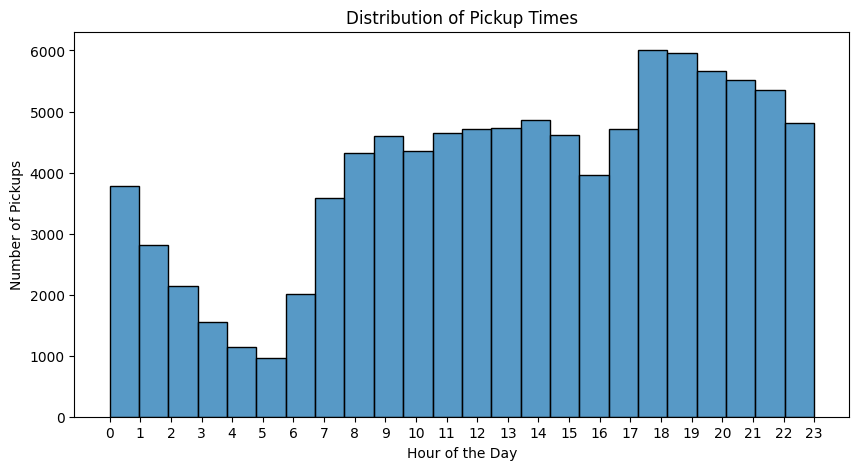

In [254]:
# Histogram of Pickup Times
df['pickup_hour'] = pd.to_datetime(df['pickup_time'].astype(str)).dt.hour
plt.figure(figsize=(10, 5))
sns.histplot(df['pickup_hour'], bins=24, kde=False)
plt.title('Distribution of Pickup Times')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Pickups')
plt.xticks(range(24))
plt.show()

From this graph we can see the distribution of pickups at different hours of the day. We can see that the hours with most pickups are from 18 to 23 hours, and the worst around 3 to 7 am.

## 4. Model

First well drop column key

In [255]:
df.drop(["key"], axis=1, inplace=True)
df.drop(["pickup_hour"], axis=1, inplace=True)
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_time
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15,17:26:21
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05,16:52:16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18,00:35:00
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21,04:30:42
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09,07:51:00


Since we can only use numbers, well separate pickupdate into year, month and day. Same thing for pickup time. Well also use dayofweek to get a better understanding of the scenario.

In [256]:
df['pickup_date'] = pd.to_datetime(df['pickup_date'])
df['year'] = df['pickup_date'].dt.year
df['month'] = df['pickup_date'].dt.month
df['day'] = df['pickup_date'].dt.day
df['day_of_week'] = df['pickup_date'].dt.dayofweek

df = df.drop('pickup_date', axis=1)

In [257]:
df['pickup_time'] = pd.to_datetime(df['pickup_time'], format='%H:%M:%S').dt.time
df['hour'] = df['pickup_time'].apply(lambda x: x.hour)
df['minute'] = df['pickup_time'].apply(lambda x: x.minute)
df.drop(["pickup_time"], axis=1, inplace=True)
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,day_of_week,hour,minute
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,2009,6,15,0,17,26
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,2010,1,5,1,16,52
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,2011,8,18,3,0,35
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,2012,4,21,5,4,30
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,2010,3,9,1,7,51


Now well separate into train and test

In [258]:
X = df.drop('fare_amount', axis=1)
y = df['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

As a bonus, heres the model using ridge (linear regresson) with polinomial features and gridsearch to optimize alpha value.

In [259]:
pipeline = Pipeline([
    ('select', SelectKBest(score_func=f_regression)),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', Ridge())
])
param_grid = {
    'model__alpha': [0.001, 0.01, 0.1, 1, 10, 100] 
}

In [260]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
predictions = grid_search.predict(X_test)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

c:\Users\juanv\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.13092e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\juanv\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.13037e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\juanv\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.1264e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\juanv\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_ridge.py:204: LinAlgWarning: Ill-conditioned matrix (rcond=1.13111e-17): result may not be accurate.
  return linalg.solve(

In [262]:
print(f'Mean Squared Error: {mse}, Root Mean Squared Error: {rmse}, R^2 Score: {r2}')

Mean Squared Error: 20.002470018430724, Root Mean Squared Error: 4.4724121029295505, R^2 Score: 0.7053666636890825


With a R^2 we can asume the model explains arount 70.5% of the data. Not a very high number but good enough for a simple model.